<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jcc/03-BERT-beto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo a evaluar JCC: BERT

En esta notebook se presentan los experimentos sobre la estrategia de representación y técnica de aprendizaje *avanzada* utilizada para las JCC de  la Universidad Nacional de La Plata.

Para ello vamos a tomar el texto de la consulta de los correos y aplicar BERT con el modelo pre-entrenado en español (BETO - Departamento de Computación de la Universidad de Chile).


## Instalación de librerías

Se instalan dos librerías que no están en el entorno Colab:
- *simpletransformers* (para entrenar Bert),
- requests (para consumir funciones propias de Github),
- wget (para la descarga de archivos).

In [1]:
!pip install simpletransformers
!pip install requests
!pip install wget

     |████████████████████████████████| 231 kB 30.6 MB/s 
     |████████████████████████████████| 3.1 MB 55.0 MB/s 
     |████████████████████████████████| 290 kB 61.6 MB/s 
     |████████████████████████████████| 1.7 MB 45.5 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 3.3 MB 17.5 MB/s 
     |████████████████████████████████| 1.2 MB 36.9 MB/s 
     |████████████████████████████████| 8.3 MB 33.7 MB/s 
     |████████████████████████████████| 895 kB 32.1 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 43.9 MB/s 
     |████████████████████████████████| 97 kB 6.3 MB/s 
     |████████████████████████████████| 180 kB 55.6 MB/s 
     |████████████████████████████████| 139 kB 60.1 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 243 kB 57.3 MB/s 
     |████████████████████████████████| 1.3 MB 34.5 MB/s 
     |████████████████

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=bdf18e1b3863af565ab18a817aa34259a053511a22d739cd9ced58881a119d22
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


### Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/jcc/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, separar_x_y_rna

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:

import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/jcc/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos_bert

## Carga del dataset con los correos

Se cargan los datos y se realiza el balanceo de clases:

In [4]:
from funciones_dataset import get_clases, cargar_dataset
from os import path
import warnings
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/consolidado_jcc/'
TRAIN_FILE = 'correos-train-80.csv'
TEST_FILE = 'correos-test-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Cantidad de clases
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')


Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (800, 24)
El conjunto de testeo tiene la dimensión: (200, 24)


### Pre-procesamiento de los datos

Se preparan los datos para el entrenamiento de BERT:

In [5]:
train_df = train_df[['Consulta', 'clase']]
train_df.columns = ['text', 'labels']
test_df = test_df[['Consulta', 'clase']]
test_df.columns = ['text', 'labels']

# Cambio los integers por las etiquetas
train_df.labels = etiquetas[train_df.labels]
test_df.labels = etiquetas[test_df.labels]

# Las vuelvo a pasar a números 0-N para evitar conflictos con simpletransformers
# Este paso está fijo para estos experimentos
dict_clases_id = {'Otras Consultas': 0,
                            'Ingreso a la Universidad': 1,
                            'Boleto Universitario': 2,
                            'Requisitos de Ingreso': 3}

#train_df['labels'].replace(dict_clases_id, inplace=True)
#test_df['labels'].replace(dict_clases_id, inplace=True)

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.labels.unique()), train_df.labels.unique()))

Existen 20 clases: ['Inscripción a Cursadas' 'Cambio de Carrera' 'Reincorporación'
 'Ingreso a la Universidad' 'Boleto Universitario'
 'Pedido de Certificados' 'Exámenes' 'Requisitos de Ingreso' 'Cursadas'
 'Situación Académica' 'Vacunas Enfermería' 'Consulta por Legajo'
 'Problemas con la Clave' 'Consulta sobre Título Universitario'
 'Certificados Web' 'Carga de Notas' 'Simultaneidad de Carreras'
 'Cambio de Comisión' 'Consulta por Equivalencias' 'Datos Personales'].


## Elección de un modelo monolenguaje pre-entrenado

La librería *simpletransformers* se basa en la librería *Transformers* de HuggingFace. Esto permite utilizar todos los modelos pre-entrenados disponibles en la [Transformers library](https://huggingface.co/transformers/pretrained_models.html) que son provistos por toda la comunidad de desarrolladores. Para ver cuales son los modelos disponibles, se puede ingresar a [https://huggingface.co/models](https://huggingface.co/models).

En nuestro caso, vamos a utilizar el modelo `dccuchile/bert-base-spanish-wwm-cased`. Este modelo está pre-entrenado por un equipo de investigadores del Departamento de Computación de la Universidad de Chile.

### Definición del Modelo para Clasificación

Se carga el modelo pre-entrenado BETO con la respectiva definición de hiperparámetros para el entrenamiento:

In [6]:
from simpletransformers.classification import ClassificationModel

# Cantidad de epochs
epocas = 4

# Hiperparámetros
train_args = {
        'overwrite_output_dir': True,
        'num_train_epochs': epocas,
        'fp16': True,
        'learning_rate': 4e-5,
        'do_lower_case': True,
        'use_early_stopping': True,
        }

# Creamos el ClassificationModel
model = ClassificationModel(
    model_type='bert', 
#    model_name='bert-base-multilingual-cased',
    model_name='dccuchile/bert-base-spanish-wwm-cased',
    num_labels=CANTIDAD_CLASES,
    use_cuda=False,
    args=train_args
)

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchi

Downloading:   0%|          | 0.00/236k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/469k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Se verifican los parámetros del modelo:

In [7]:
model.args

ClassificationArgs(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=True, adafactor_scale_parameter=True, adafactor_warmup_init=True, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=True, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=2000, evaluate_during_training_verbose=False, evaluate_each_epoch=True, fp16=False, gradient_accumulation_steps=1, learning_rate=4e-05, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, 

## Entrenamiento

Se entrena el modelo con el dataset de train en función de los hiperparámetros:

In [8]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(train_df.labels)
train_df.labels = le.transform(train_df.labels)

In [9]:
# Entrenamos el modelo
model.train_model(train_df)

  0%|          | 0/800 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/100 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/100 [00:00<?, ?it/s]

(400, 0.9774562656041235)

## Testeo del modelo entrenado

Se testea el modelo sobre el 20% de instancias reservadas para esta tarea:

In [10]:
# Ejecutamos las predicciones sobre testing
predictions, raw_outputs = model.predict(list(test_df.text))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [11]:
predictions = le.inverse_transform(predictions)

In [12]:
# Evaluamos el modelo
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Calculo las métricas sobre test para el paper
acc_test = accuracy_score(test_df.labels, predictions)
precision_test = precision_score(test_df.labels, predictions, average='weighted')
recall_test = recall_score(test_df.labels, predictions, average='weighted')
f1_test = f1_score(test_df.labels, predictions, average='weighted')
mcc_test = matthews_corrcoef(test_df.labels, predictions)

# Genero un diccionario con los parámetro y el acc en test
dict_test = {}
dict_test['clasificador'] = 'BETO'
dict_test['accuracy'] = acc_test
dict_test['precision'] = precision_test
dict_test['recall'] = recall_test
dict_test['f1_score'] = f1_test
dict_test['mcc'] = mcc_test
 
# Paso el diccionario a dataframe y lo guardo en un archivo con fecha/hora
results_test = pd.DataFrame([dict_test])
print(results_test)

  clasificador  accuracy  precision  recall  f1_score       mcc
0         BETO      0.76   0.734599    0.76   0.74197  0.717376


In [13]:
mcc_test

0.717375701434232

Se guardan los resultados en un archivo csv:

In [14]:
# Lo guardo en un archivo
from datetime import datetime

now = datetime.now()
nombre_results_test = 'results_test.csv'

results_test.to_csv(nombre_results_test, mode='w')

### Matriz de confusión del modelo

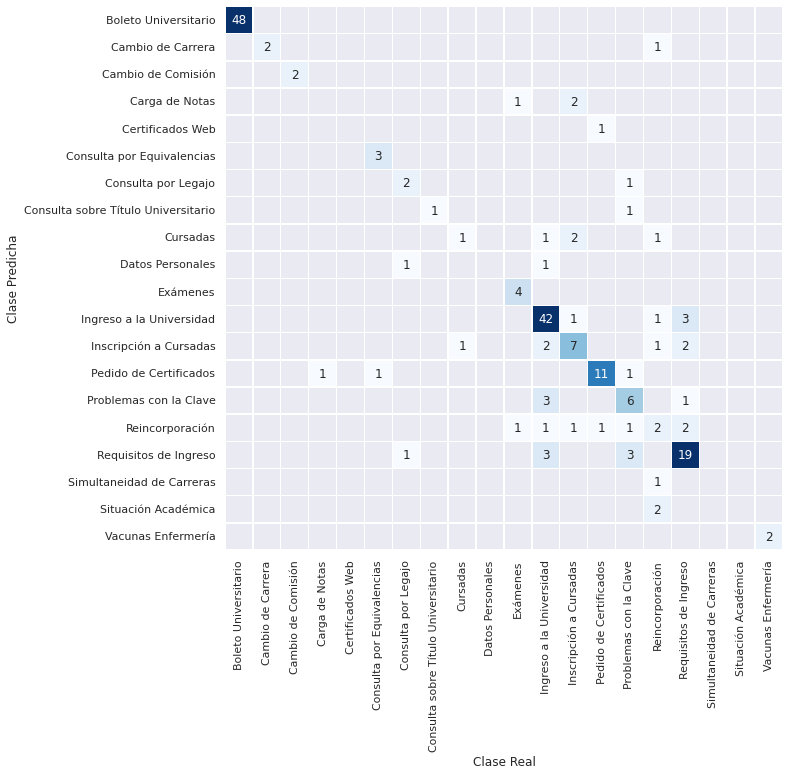

In [15]:
import numpy as np
from sklearn import metrics #Importar el módulo metrics de scikit-learn
import seaborn as sns
import matplotlib.pyplot as plt

matriz_confusion = metrics.confusion_matrix(test_df.labels, predictions)

sns.set()
my_mask = np.zeros((matriz_confusion.shape[0], matriz_confusion.shape[0]), dtype=int)
for i in range(matriz_confusion.shape[0]):
    for j in range(matriz_confusion.shape[0]):
        my_mask[i][j] = matriz_confusion[i][j] == 0 
  
fig_dims = (10, 10)
plt.subplots(figsize=fig_dims)

ax = sns.heatmap(matriz_confusion,
                 xticklabels=etiquetas,
                 annot=True, 
                 fmt="d", 
                 linewidths=.5, 
                 cmap="Blues", 
                 cbar=False, 
                 mask=my_mask, 
                 vmax=15)

plt.gcf().set_size_inches(10, 10)
plt.xticks(rotation=90, ha="center")
plt.yticks(np.arange(len(etiquetas))+0.5, etiquetas, rotation='horizontal')

plt.xlabel('Clase Real')
plt.ylabel('Clase Predicha');

plt.show()

### Prueba del modelo con un ejemplo real

In [16]:
test_correo = "no tengo dinero para viajar"

predictions, raw_outputs = model.predict([test_correo])

print(etiquetas[predictions[0]])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Boleto Universitario


# Referencias
- https://towardsdatascience.com/bert-text-classification-in-a-different-language-6af54930f9cb
- https://medium.com/dair-ai/beto-spanish-bert-420e4860d2c6